### Setting up GPU memory growth to avoid OOM errors

In [1]:
import tensorflow as tf

# avoid oom errors by setting GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.set_logical_device_configuration(gpu, [tf.config.LogicalDeviceConfiguration(memory_limit=2048)])
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Hyperparameters

In [2]:
# model hyperparameter
epochs = 10
batch_size = 16

# hyperparameter for contrastive loss
margin = 1

### Data Loading

In [3]:
from tensorflow import keras

(image_train, label_train), (image_test, label_test) = keras.datasets.mnist.load_data()

In [4]:
image_train = image_train.astype('float32')
image_test = image_test.astype('float32')

### Normalize Data

In [5]:
image_train = image_train / 255.0
image_test = image_test / 255.0

### Splitting Data

In [6]:
X_train, X_val = image_train[:30000], image_train[30000:]
y_train, y_val = label_train[:30000], label_train[30000:]
del image_train, label_train

In [7]:
print('Total image for training:', len(X_train))
print('Total image for validation:', len(X_val))

Total image for training: 30000
Total image for validation: 30000


In [8]:
print('Total label for training:', len(y_train))
print('Total label for validation:', len(y_val))

Total label for training: 30000
Total label for validation: 30000


### Create Image Pair

Siamese Networks are neural networks which share weights between two or more sister networks, each producing embedding vectors of its respective inputs.

In supervised similarity learning, the networks are then trained to maximize the contrast (distance) between embeddings of inputs of different classes, while minimizing the distance between embeddings of similar classes, resulting in embedding spaces that reflect the class segmentation of the training inputs.

We will train the model to differentiate between digits of different classes. For example, digit 0 needs to be differentiated from the rest of the digits (1 through 9), digit 1 - from 0 and 2 through 9, and so on. To carry this out, we will select N random images from class A (for example, for digit 0) and pair them with N random images from another class B (for example, for digit 1). Then, we can repeat this process for all classes of digits (until digit 9). Once we have paired digit 0 with other digits, we can repeat this process for the remaining classes for the rest of the digits (from 1 until 9).

In [9]:
def make_pairs(x, y):
    """Creates a tuple containing image pairs with corresponding label.

    Arguments:
        x: List containing images, each index in this list corresponds to one image.
        y: List containing labels, each label with datatype of `int`.

    Returns:
        Tuple containing two numpy arrays as (pairs_of_samples, labels),
        where pairs_of_samples' shape is (2len(x), 2,n_features_dims) and
        labels are a binary array of shape (2len(x)).
    """
    
    n_classes = max(y) + 1
    digit_indices = [np.where(y == i)[0] for i in range(n_classes)]
    
    pairs, labels = [], []
    for i in range(len(x)):
        # add matching example
        x1 = x[i]
        label1 = y[i]
        idx = random.choice(digit_indices[label1])
        x2 = x[idx]
        
        pairs += [[x1, x2]]
        labels += [1]
        
        # add non matching example
        label2 = random.randint(0, n_classes - 1)
        while label2 == label1:
            label2 = random.randint(0, n_classes - 1)
        
        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]
        
        pairs += [[x1, x2]]
        labels += [0]
    return np.array(pairs), np.array(labels).astype('float32')

In [10]:
import numpy as np
import random

# make train pairs
pairs_train, labels_train = make_pairs(X_train, y_train)

# make validation pairs
pairs_val, labels_val = make_pairs(X_val, y_val)

# make test pairs
pairs_test, labels_test = make_pairs(image_test, label_test)

In [11]:
# split training pairs
X_train_1 = pairs_train[:, 0]
X_train_2 = pairs_train[:, 1]

# split validation pairs
X_val_1 = pairs_val[:, 0]
X_val_2 = pairs_val[:, 1]

# split testing pairs
X_test_1 = pairs_test[:, 0]
X_test_2 = pairs_test[:, 1]

### Visualize the Pairs and Labels

In [12]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    """Creates a plot of pairs and labels, and prediction if it's test dataset.

    Arguments:
        pairs: Numpy Array, of pairs to visualize, having shape
               (Number of pairs, 2, 28, 28).
        to_show: Int, number of examples to visualize (default is 6)
                `to_show` must be an integral multiple of `num_col`.
                 Otherwise it will be trimmed if it is greater than num_col,
                 and incremented if if it is less then num_col.
        num_col: Int, number of images in one row - (default is 3)
                 For test and train respectively, it should not exceed 3 and 7.
        predictions: Numpy Array of predictions with shape (to_show, 1) -
                     (default is None)
                     Must be passed when test=True.
        test: Boolean telling whether the dataset being visualized is
              train dataset or test dataset - (default False).

    Returns:
        None.
    """

    num_row = to_show // num_col if to_show // num_col != 0 else 1
    to_show = num_row * num_col

    fig, axs = plt.subplots(num_row, num_col, figsize=(5,5))
    for i in range(to_show):
        if num_row == 1:
            ax = axs[i % num_col]
        else:
            ax = axs[i // num_col, i % num_col]

        ax.imshow(tf.concat([pairs[i][0], pairs[i][1]], axis=1), cmap='gray')
        ax.set_axis_off()
        if test:
            ax.set_title("Similary: {} | Distance: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Similar: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()

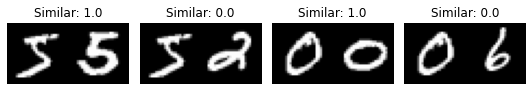

In [13]:
from matplotlib import pyplot as plt

visualize(pairs_train[:-1], labels_train[:-1], to_show=4, num_col=4)

### Define the Model

There are two input layers, each leading to its own network, which produces embeddings. A Lambda layer then merges them using an Euclidean distance and the merged output is fed to the final network.

In [14]:
def euclidean_distance(vec):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vec
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

In [15]:
def loss(margin=1):
    """Provides 'constrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'constrastive_loss' function with data ('margin') attached.
    """

    def contrastive_loss(y_true, y_pred):
        """Calculates the constrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing constrastive loss as floating point value.
        """

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean((1 - y_true) * square_pred + (y_true) * margin_square)
    return contrastive_loss

In [16]:
from keras import layers
from keras import Model

with tf.device('/GPU:0'):
    # define base model
    input = layers.Input((28,28,1))
    x = layers.BatchNormalization()(input)
    x = layers.Conv2D(4, (5,5), activation='tanh')(x)
    x = layers.AveragePooling2D(2)(x)
    x = layers.Conv2D(16, (5,5), activation='tanh')(x)
    x = layers.AveragePooling2D(2)(x)
    x = layers.Flatten()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(10, activation='tanh')(x)
    model = Model(input, x)

    # define input layer for siamese network
    input_1 = layers.Input((28,28,1))
    input_2 = layers.Input((28,28,1))

    # create twins network
    model1 = model(input_1)
    model2 = model(input_2)

    # merge the 
    merge_layer = layers.Lambda(euclidean_distance)([model1, model2])
    normal_layer = layers.BatchNormalization()(merge_layer)
    output = layers.Dense(1, activation='sigmoid')(normal_layer)
    siamese = keras.Model(inputs=[input_1, input_2], outputs=output)
    siamese.compile(loss=loss(margin=margin), optimizer='rmsprop', metrics=['accuracy'])

In [17]:
siamese.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 model (Functional)             (None, 10)           5318        ['input_2[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 1)            0           ['model[0][0]',            

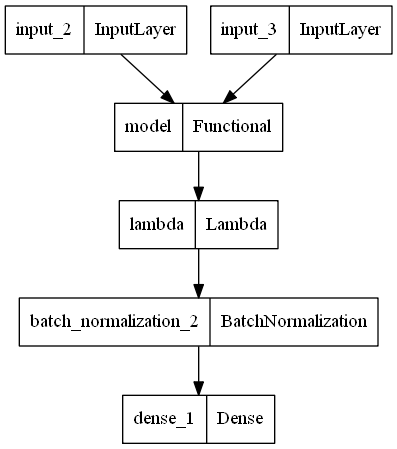

In [18]:
from keras.utils import plot_model

plot_model(siamese)

In [19]:
history = siamese.fit(
    [X_train_1, X_train_2],
    labels_train,
    validation_data=([X_val_1, X_val_2], labels_val),
    batch_size=batch_size,
    epochs=epochs
)

Epoch 1/10
3750/3750 [==============================] - 52s 13ms/step - loss: 0.0887 - accuracy: 0.8881 - val_loss: 0.0326 - val_accuracy: 0.9571
Epoch 2/10
3750/3750 [==============================] - 51s 14ms/step - loss: 0.0502 - accuracy: 0.9339 - val_loss: 0.0278 - val_accuracy: 0.9635
Epoch 3/10
3750/3750 [==============================] - 50s 13ms/step - loss: 0.0422 - accuracy: 0.9455 - val_loss: 0.0204 - val_accuracy: 0.9739
Epoch 4/10
3750/3750 [==============================] - 47s 13ms/step - loss: 0.0389 - accuracy: 0.9495 - val_loss: 0.0194 - val_accuracy: 0.9752
Epoch 5/10
3750/3750 [==============================] - 51s 14ms/step - loss: 0.0362 - accuracy: 0.9534 - val_loss: 0.0188 - val_accuracy: 0.9760
Epoch 6/10
3750/3750 [==============================] - 51s 14ms/step - loss: 0.0343 - accuracy: 0.9556 - val_loss: 0.0162 - val_accuracy: 0.9786
Epoch 7/10
3750/3750 [==============================] - 48s 13ms/step - loss: 0.0319 - accuracy: 0.9595 - val_loss: 0.0163 -

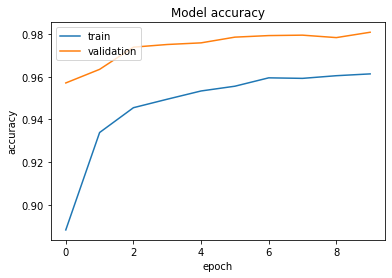

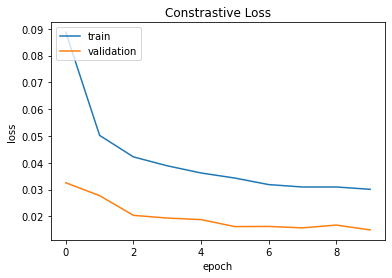

In [20]:
def plt_metric(history, metric, title, has_valid=True):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()

# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

# Plot the constrastive loss
plt_metric(history=history.history, metric="loss", title="Constrastive Loss")

In [21]:
accuracy = siamese.evaluate([X_test_1, X_test_2], labels_test)
print('Test loss, Test Accuracy:', accuracy)

625/625 [==============================] - 3s 4ms/step - loss: 0.0143 - accuracy: 0.9815
Test loss, Test Accuracy: [0.014325650408864021, 0.9814500212669373]


625/625 [==============================] - 2s 3ms/step


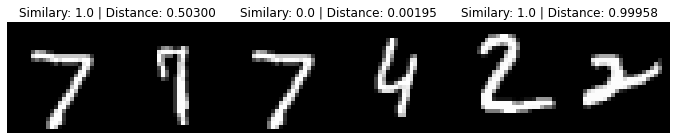

In [22]:
# Note: the more the distance, more similarity on picture
predictions = siamese.predict([X_test_1, X_test_2])
visualize(pairs_test, labels_test, to_show=3, predictions=predictions, test=True)